In [1]:
import os
os.chdir("../../../")

import numpy as np
import pandas as pd

from scripts.python.tsa.mtsmodel import *
from scripts.python.tsa.ts_eval import *

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

import sys
import arviz as az
try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install --upgrade bambi
    import bambi as bmb

from stargazer.stargazer import Stargazer, LineLocation
import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parent_dir = os.path.dirname(os.getcwd())
ship = pd.read_excel(parent_dir + "/Port Calls.xlsx", sheet_name=0)

In [3]:
psg_ship = ship[ship["SubType"] == "Cruise Ship"]

timecols = ["departure_dt_pos_utc",
            "prev_departure_dt_pos_utc",
            "arrival_dt_pos_utc",
            "date"]

for col in timecols:
    psg_ship[col] = pd.to_datetime(psg_ship[col])

psg_ship = (psg_ship[(psg_ship["arrival_dt_pos_utc"] >= "2019-01-01")
                     & (psg_ship["arrival_dt_pos_utc"] <= "2023-01-01")]
            .reset_index()
            .drop("index", axis=1))
psg_ship.head(5)

,mmsi,imo,vessel_name,Country,Port,vessel_type,arrival_dt_pos_utc,arrival_draught,arrival_destination,count_ais,...,SubType,match_ihs,ihs_imo,ExName_perdate,ExName_eff_until_date,ihs_mmsi,fin_match,lev_ShipName,lev_ExName,lev_ExName_perdate
0,229136000,9188647,CARNIVAL SPIRIT,Fiji,SUVA HARBOR,Passenger,2019-02-17 18:48:11,8.2,MARE,610,...,Cruise Ship,imo,9188647,CARNIVAL SPIRIT,2023-03-30,311001095.0,okay - match ship name,0.0,1.0,0.0
1,229136000,9188647,CARNIVAL SPIRIT,Fiji,SUVA HARBOR,Passenger,2019-11-15 18:42:06,8.2,SUVA,608,...,Cruise Ship,imo,9188647,CARNIVAL SPIRIT,2023-03-30,311001095.0,okay - match ship name,0.0,1.0,0.0
2,229136000,9188647,CARNIVAL SPIRIT,Fiji,SUVA HARBOR,Passenger,2019-12-23 18:57:52,8.5,ISLE OF PINES,722,...,Cruise Ship,imo,9188647,CARNIVAL SPIRIT,2023-03-30,311001095.0,okay - match ship name,0.0,1.0,0.0
3,229378000,9616230,EUROPA 2,Fiji,SUVA HARBOR,Passenger,2019-02-06 19:48:10,6.3,LAUTOKA,784,...,Cruise Ship,imo x mmsi,9616230,EUROPA 2,2023-03-30,NaN,okay - match ship name,0.0,1.0,0.0
4,229857000,9224726,CARNIVAL LEGEND,Fiji,SUVA HARBOR,Passenger,2019-01-01 18:09:35,8.2,SUVA,1233,...,Cruise Ship,imo,9224726,CARNIVAL LEGEND,2023-03-30,311001094.0,okay - match ship name,0.0,1.0,0.0


In [4]:
psg_ship_count = (psg_ship[["Country", "mmsi", "year", "month"]]
                      .groupby(by=["Country", "year", "month"])
                      .count()
                      .reset_index())
psg_ship_count["date"] = [
    str(y) + "-" + str(m) + "-01"
    for y, m in zip(psg_ship_count["year"], psg_ship_count["month"])
]

psg_ship_count["date"] = pd.to_datetime(psg_ship_count["date"])
psg_ship_count = psg_ship_count.pivot(index='date',
                                      columns="Country",
                                      values='mmsi').fillna(0)
psg_ship_count.columns.name = None
date_range = pd.DataFrame(pd.date_range(start="2019-01-01",
                                        end="2022-12-01",
                                        freq="MS"),
                          columns=["date"])
psg_ship_count = date_range.merge(psg_ship_count, how="left",
                                  on="date").fillna(0)
psg_ship_count.head(5)

,date,Fiji,Kiribati,Marshall Islands,Micronesia,Palau,Papua New Guinea,Samoa,Solomon Islands,Tonga,Vanuatu
0,2019-01-01,9.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,11.0
1,2019-02-01,13.0,0.0,0.0,0.0,4.0,6.0,0.0,2.0,2.0,4.0
2,2019-03-01,7.0,0.0,0.0,1.0,4.0,10.0,0.0,1.0,3.0,6.0
3,2019-04-01,12.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,4.0,7.0
4,2019-05-01,11.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,4.0


In [70]:
psg_ship_count

,date,Fiji,Kiribati,Marshall Islands,Micronesia,Palau,Papua New Guinea,Samoa,Solomon Islands,Tonga,Vanuatu
0,2019-01-01,9.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,11.0
1,2019-02-01,13.0,0.0,0.0,0.0,4.0,6.0,0.0,2.0,2.0,4.0
2,2019-03-01,7.0,0.0,0.0,1.0,4.0,10.0,0.0,1.0,3.0,6.0
3,2019-04-01,12.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,4.0,7.0
4,2019-05-01,11.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,4.0
5,2019-06-01,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
6,2019-07-01,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0
7,2019-08-01,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0
8,2019-09-01,13.0,0.0,0.0,0.0,4.0,7.0,0.0,2.0,0.0,6.0
9,2019-10-01,12.0,0.0,0.0,0.0,1.0,11.0,0.0,5.0,3.0,7.0


In [5]:
psg_ship_count.to_csv(os.getcwd() + "/data/tourism/pic_cruise_count.csv", encoding="utf-8")

In [5]:
import statsmodels.formula.api as smf

In [76]:
psg_ship_count.columns = [col.lower().replace(" ", "_") for col in psg_ship_count]


VANUATU's Official and Avaition Data.

 Create Loaded Factor for VANUATU:

 Regression VANUATU:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ratio_sigma, Intercept, covid, stringency_index, covid:stringency_index, C(quarter), vanuatu_travel, cruise]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.369,0.065,0.250,0.494,0.001,0.001,6972.153,5652.585,1.000
covid,-0.453,0.076,-0.599,-0.315,0.001,0.001,5563.178,5267.802,1.000
stringency_index,-0.005,0.002,-0.008,-0.001,0.000,0.000,3375.612,4710.450,1.002
covid:stringency_index,0.004,0.002,-0.001,0.008,0.000,0.000,3153.598,4706.957,1.002
C(quarter)[2],0.024,0.031,-0.033,0.085,0.000,0.000,4703.842,4632.676,1.000
C(quarter)[3],0.118,0.033,0.058,0.179,0.000,0.000,5090.367,5062.414,1.001
C(quarter)[4],0.061,0.034,-0.006,0.125,0.001,0.000,4595.223,5119.773,1.002
vanuatu_travel,0.224,0.093,0.046,0.400,0.001,0.001,5168.106,5590.058,1.001
cruise,0.011,0.005,0.001,0.021,0.000,0.000,5365.740,5576.636,1.001
ratio_sigma,0.071,0.009,0.055,0.088,0.000,0.000,4873.735,5140.018,1.001


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable: ratio}} \
\cr \cline{2-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 C(quarter)[T.2] & & 0.015$^{}$ & 0.024$^{}$ \\
& & (0.034) & (0.035) \\
 C(quarter)[T.3] & & 0.108$^{**}$ & 0.117$^{**}$ \\
& & (0.050) & (0.052) \\
 C(quarter)[T.4] & & 0.068$^{}$ & 0.061$^{}$ \\
& & (0.045) & (0.042) \\
 Intercept & -0.261$^{***}$ & 0.416$^{***}$ & 0.370$^{***}$ \\
& (0.048) & (0.093) & (0.095) \\
 covid & & -0.510$^{***}$ & -0.456$^{***}$ \\
& & (0.083) & (0.080) \\
 covid:stringency_index & & 0.005$^{*}$ & 0.004$^{*}$ \\
& & (0.003) & (0.002) \\
 cruise & & & 0.011$^{**}$ \\
& & & (0.005) \\
 stringency_index & & -0.006$^{***}$ & -0.005$^{***}$ \\
& & (0.002) & (0.002) \\
 vanuatu_travel & 1.077$^{***}$ & 0.297$^{***}$ & 0.225$^{***}$ \\
& (0.207) & (0.082) & (0.060) \\
\hline \\[-1.8ex]
 Observations & 43 & 43 & 43 \\
 $R^2$ & 0.537 

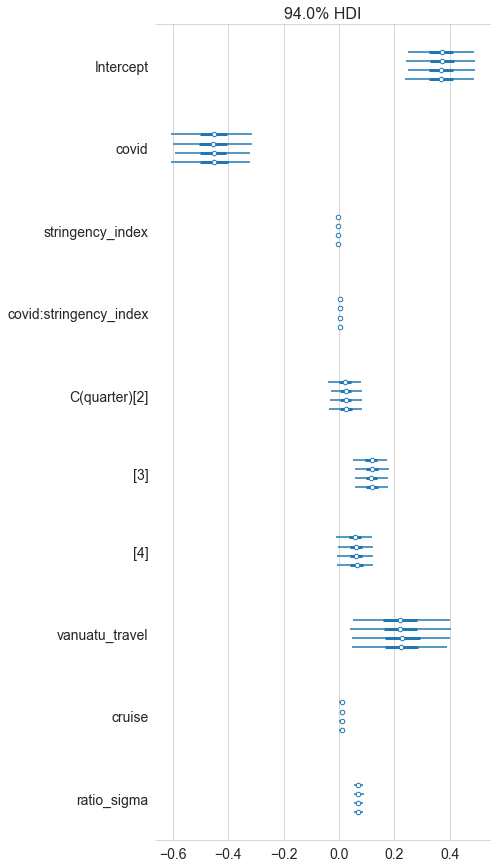

In [83]:

for country in ["vanuatu"]:

    mod = RatioPipe(country=country, data=None)
    print(f"\n{country.upper()}'s Official and Avaition Data.")
    mod.read_and_merge()

    print(f"\n Create Loaded Factor for {country.upper()}:")
    mod.transform()
    
    mod.data = (mod.data.merge(psg_ship_count[["date", str(country)]])
                    .rename({str(country): "cruise"}, axis=1))
    mod.data["quarter"] = mod.data["date"].dt.quarter
    optimal_lag = int(4 * (len(mod.data)/100) ** (2/9)) + 1
    print(f"\n Regression {country.upper()}:")
    
    res = smf.ols(
        "ratio ~" + str(country) + "_travel", 
         data=mod.data).fit(cov_type='HAC', cov_kwds={'maxlags': optimal_lag, 
                                                      "use_correction": True})
    res2 = smf.ols(
        "ratio ~ covid*stringency_index + C(quarter) +" + str(country) + "_travel", 
         data=mod.data).fit(cov_type='HAC', cov_kwds={'maxlags': optimal_lag, 
                                                      "use_correction": True})

    res3 = smf.ols(
        "ratio ~ covid*stringency_index + C(quarter) +" + str(country) + "_travel + cruise", 
         data=mod.data).fit(cov_type='HAC', cov_kwds={'maxlags': optimal_lag, 
                                                      "use_correction": True})
    
    
    blr = bmb.Model(
        "ratio ~ covid*stringency_index + C(quarter) +" + str(country) + "_travel + cruise", 
         data=mod.data)
    trace = blr.fit(tune=2000, draws=2000, return_inferencedata=True)
    display(az.summary(trace, round_to=3))
    az.plot_forest(trace)

print(Stargazer([res, res2, res3]).render_latex())

In [31]:
az.summary(trace, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.366,0.068,0.245,0.502,0.001,0.001,5486.144,5430.067,1.000
covid,-0.407,0.073,-0.546,-0.271,0.001,0.001,3542.624,4714.711,1.001
stringency_index,-0.005,0.001,-0.008,-0.002,0.000,0.000,3465.793,4215.601,1.001
covid:stringency_index,0.004,0.002,-0.000,0.008,0.000,0.000,2617.410,3769.037,1.001
C(quarter)[2],0.054,0.035,-0.010,0.119,0.001,0.000,2814.365,4277.623,1.001
C(quarter)[3],0.092,0.032,0.035,0.154,0.001,0.000,3022.413,4211.589,1.001
C(quarter)[4],0.061,0.029,0.006,0.115,0.001,0.000,3344.346,4359.906,1.000
tonga_travel,0.155,0.237,-0.303,0.597,0.003,0.002,4885.676,5442.193,1.000
cruise,-0.014,0.010,-0.033,0.004,0.000,0.000,3894.022,5025.556,1.001
ratio_sigma,0.052,0.007,0.039,0.066,0.000,0.000,4705.525,5043.757,1.001


In [30]:
print(az.summary(trace, round_to=3).iloc[[7,8,9], :4].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% \\
\midrule
tonga\_travel &  0.155 &  0.237 &  -0.303 &    0.597 \\
cruise       & -0.014 &  0.010 &  -0.033 &    0.004 \\
ratio\_sigma  &  0.052 &  0.007 &   0.039 &    0.066 \\
\bottomrule
\end{tabular}

